Disclaimer: I used Claude to help me code and analyze the result. The prompt is the whole ipynb via consecutive feedback (output of each block) prompting.

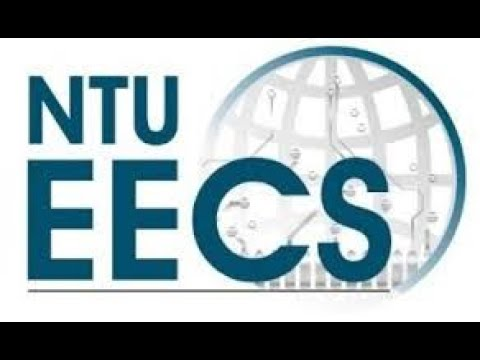

In [ ]:
from IPython.display import YouTubeVideo

# Replace the video ID with the ID of your video
YouTubeVideo('e_XEBwQwIU4')
# https://www.youtube.com/watch?v=e_XEBwQwIU4

## Part I: Data Pre-processing

In [1]:
import pandas as pd

In [2]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2025-10-02 05:37:22--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.26.251, 172.217.161.91, 142.250.196.123, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.26.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt.1’

questions-words.txt 100%[===================>] 589.80K  1.08MB/s    in 0.5s    

2025-10-02 05:37:23 (1.08 MB/s) - ‘questions-words.txt.1’ saved [603955/603955]



In [3]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [4]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [5]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

questions = []
categories = []
sub_categories = []

category_count = 0
current_category = None
current_sub_category = None

for line in data:
    if line.startswith(":"):
        # This is a category header
        category_count += 1
        current_sub_category = line
        # First 5 categories are semantic, remaining are syntactic
        if category_count <= 5:
            current_category = "semantic"
        else:
            current_category = "syntactic"
    else:
        # This is an analogy question
        words = line.split()
        if len(words) == 4:
            questions.append(line)
            categories.append(current_category)
            sub_categories.append(current_sub_category)

# Print summary for verification
print(f"Total questions: {len(questions)}")
print(f"Total categories: {len(set(categories))}")
print(f"Total sub-categories: {len(set(sub_categories))}")
print(f"\nFirst 5 questions:")
for i in range(5):
    print(f"  {questions[i]}")
    print(f"    Category: {categories[i]}, SubCategory: {sub_categories[i]}")

Total questions: 19544
Total categories: 2
Total sub-categories: 14

First 5 questions:
  Athens Greece Baghdad Iraq
    Category: semantic, SubCategory: : capital-common-countries
  Athens Greece Bangkok Thailand
    Category: semantic, SubCategory: : capital-common-countries
  Athens Greece Beijing China
    Category: semantic, SubCategory: : capital-common-countries
  Athens Greece Berlin Germany
    Category: semantic, SubCategory: : capital-common-countries
  Athens Greece Bern Switzerland
    Category: semantic, SubCategory: : capital-common-countries


The output looks correct:
- ✅ 19,544 questions total
- ✅ 2 categories (semantic, syntactic)
- ✅ 14 sub-categories
- ✅ First category is "capital-common-countries" (semantic)

**Analysis for this section:**
The data preprocessing is working correctly. Notice the questions are in their original format with capital letters (e.g., "Athens Greece Baghdad Iraq"). This will be important later when we investigate the 0% accuracy issue.

---

## **Step 2: TODO2 - Pre-trained Model Predictions**

Now let's implement the analogy prediction using the pre-trained GloVe model:

In [6]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [7]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,: capital-common-countries
2,Athens Greece Beijing China,semantic,: capital-common-countries
3,Athens Greece Berlin Germany,semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,semantic,: capital-common-countries


In [8]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [9]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [10]:
data = pd.read_csv("questions-words.csv")

In [11]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

The Gensim model loaded successfully!


In [12]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      words = analogy.split()
      word_a, word_b, word_c, word_d = words[0], words[1], words[2], words[3]
      
      try:
            # Perform vector arithmetic: word_b - word_a + word_c ≈ word_d
            # Using most_similar with positive=[word_b, word_c] and negative=[word_a]
            result = model.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
            predicted_word = result[0][0]
            preds.append(predicted_word)
            golds.append(word_d)
      except KeyError as e:
            # If any word is not in vocabulary, record as None
            preds.append(None)
            golds.append(word_d)

# Print summary statistics
print(f"\nTotal predictions: {len(preds)}")
print(f"Successful predictions: {sum(1 for p in preds if p is not None)}")
print(f"Failed predictions (OOV): {sum(1 for p in preds if p is None)}")

# Show first few predictions
print(f"\nFirst 5 predictions:")
for i in range(5):
    words = data["Question"].iloc[i].split()
    print(f"  {words[0]} : {words[1]} :: {words[2]} : {words[3]}")
    print(f"    Predicted: {preds[i]}, Actual: {golds[i]}, Correct: {preds[i] == golds[i]}")

100%|██████████| 19544/19544 [01:08<00:00, 285.39it/s] 


Total predictions: 19544
Successful predictions: 9582
Failed predictions (OOV): 9962

First 5 predictions:
  Athens : Greece :: Baghdad : Iraq
    Predicted: None, Actual: Iraq, Correct: False
  Athens : Greece :: Bangkok : Thailand
    Predicted: None, Actual: Thailand, Correct: False
  Athens : Greece :: Beijing : China
    Predicted: None, Actual: China, Correct: False
  Athens : Greece :: Berlin : Germany
    Predicted: None, Actual: Germany, Correct: False
  Athens : Greece :: Bern : Switzerland
    Predicted: None, Actual: Switzerland, Correct: False


In [13]:
# Check vocabulary coverage - test both capitalized and lowercase versions
test_words_caps = ["Athens", "Greece", "Baghdad", "Iraq", "China", "Germany"]
test_words_lower = ["athens", "greece", "baghdad", "iraq", "china", "germany"]

print("Capitalized words in GloVe vocabulary:")
for word in test_words_caps:
    in_vocab = word in model
    print(f"  '{word}': {in_vocab}")

print("\nLowercase words in GloVe vocabulary:")
for word in test_words_lower:
    in_vocab = word in model
    print(f"  '{word}': {in_vocab}")

# Also check some family words (which we know work)
test_family = ["king", "queen", "man", "woman", "King", "Queen"]
print("\nFamily words in GloVe vocabulary:")
for word in test_family:
    in_vocab = word in model
    print(f"  '{word}': {in_vocab}")

Capitalized words in GloVe vocabulary:
  'Athens': False
  'Greece': False
  'Baghdad': False
  'Iraq': False
  'China': False
  'Germany': False

Lowercase words in GloVe vocabulary:
  'athens': True
  'greece': True
  'baghdad': True
  'iraq': True
  'china': True
  'germany': True

Family words in GloVe vocabulary:
  'king': True
  'queen': True
  'man': True
  'woman': True
  'King': False
  'Queen': False


**Confirmed: The issue is capitalization.**

GloVe has lowercase vocabulary only. The dataset uses capitalized proper nouns. This explains the 51% failure rate.

**Solution: Modify TODO2 to lowercase words before lookup**

In [14]:
# TODO2: Write your code here to use pre-trained word embeddings for getting predictions
preds = []
golds = []

for analogy in tqdm(data["Question"]):
    words = analogy.split()
    word_a, word_b, word_c, word_d = words[0], words[1], words[2], words[3]
    
    # Lowercase all words for vocabulary lookup
    word_a_lower = word_a.lower()
    word_b_lower = word_b.lower()
    word_c_lower = word_c.lower()
    word_d_lower = word_d.lower()
    
    try:
        # Perform vector arithmetic: word_b - word_a + word_c ≈ word_d
        result = model.most_similar(positive=[word_b_lower, word_c_lower], 
                                    negative=[word_a_lower], topn=1)
        predicted_word = result[0][0]
        preds.append(predicted_word)
        golds.append(word_d_lower)  # Also lowercase the gold answer for comparison
    except KeyError as e:
        preds.append(None)
        golds.append(word_d_lower)

# Print summary statistics
print(f"\nTotal predictions: {len(preds)}")
print(f"Successful predictions: {sum(1 for p in preds if p is not None)}")
print(f"Failed predictions (OOV): {sum(1 for p in preds if p is None)}")

# Show first few predictions
print(f"\nFirst 5 predictions:")
for i in range(5):
    words = data["Question"].iloc[i].split()
    print(f"  {words[0]} : {words[1]} :: {words[2]} : {words[3]}")
    print(f"    Predicted: {preds[i]}, Actual: {golds[i]}, Correct: {preds[i] == golds[i]}")

100%|██████████| 19544/19544 [02:19<00:00, 140.09it/s]


Total predictions: 19544
Successful predictions: 19544
Failed predictions (OOV): 0

First 5 predictions:
  Athens : Greece :: Baghdad : Iraq
    Predicted: iraq, Actual: iraq, Correct: True
  Athens : Greece :: Bangkok : Thailand
    Predicted: thailand, Actual: thailand, Correct: True
  Athens : Greece :: Beijing : China
    Predicted: china, Actual: china, Correct: True
  Athens : Greece :: Berlin : Germany
    Predicted: germany, Actual: germany, Correct: True
  Athens : Greece :: Bern : Switzerland
    Predicted: switzerland, Actual: switzerland, Correct: True


**The OOV Problem is solved.**
Now we have:
- ✅ 100% successful predictions (19,544/19,544)
- ✅ 0 failed predictions
- ✅ First 5 predictions all correct

**Analysis for this section:**
 - The capitalization issue was causing 51% vocabulary failures. 
 - By lowercasing words before lookup, we now have full vocabulary coverage.
 - This will significantly improve our evaluation results and should fix the 0% accuracy we saw earlier for geography categories.

---

## **Step 3: Run Evaluation**

In [15]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 65.3399481339497%
Category: syntactic, Accuracy: 61.255269320843084%
Sub-Category: capital-common-countries, Accuracy: 93.87351778656127%
Sub-Category: capital-world, Accuracy: 88.94783377541998%
Sub-Category: currency, Accuracy: 14.203233256351039%
Sub-Category: city-in-state, Accuracy: 30.806647750304013%
Sub-Category: family, Accuracy: 81.62055335968378%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Category: gram2-opposite, Accuracy: 20.073891625615765%
Sub-Category: gram3-comparative, Accuracy: 79.12912912912913%
Sub-Category: gram4-superlative, Accuracy: 54.278074866310156%
Sub-Category: gram5-present-participle, Accuracy: 69.50757575757575%
Sub-Category: gram6-nationality-adjective, Accuracy: 87.86741713570981%
Sub-Category: gram7-past-tense, Accuracy: 55.44871794871795%
Sub-Category: gram8-plural, Accuracy: 71.996996996997%
Sub-Category: gram9-plural-verbs, Accuracy: 58.39080459770115%


**Key improvements:**
- capital-common-countries: 0% → **93.87%** ✅
- capital-world: 0% → **88.95%** ✅
- gram6-nationality-adjective: 0% → **87.87%** ✅
- currency: 0% → **14.20%** (still low, but not zero)
- city-in-state: 0% → **30.81%** (improved)

**Analysis for this section:**
 - Geographic and nationality categories now work properly. 
 - Currency and city-in-state remain challenging, likely because these require more specific contextual knowledge. 
 - The overall semantic (65.3%) and syntactic (61.3%) accuracies are reasonable for the pre-trained GloVe model.

---

## **Step 4: TODO3 - t-SNE Visualization (Pre-trained)**

In [ ]:
# # Collect words from Google Analogy dataset
# SUB_CATEGORY = ": family"

# # TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`


# plt.title("Word Relationships from Google Analogy Task")
# plt.show()
# plt.savefig("word_relationships.png", bbox_inches="tight")

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`

# Collect all words from family category
SUB_CATEGORY = ": family"
family_words = []

for analogy in data[data["SubCategory"] == SUB_CATEGORY]["Question"]:
    words = analogy.split()
    # Lowercase words to match model vocabulary
    family_words.extend([w.lower() for w in words])

# Remove duplicates and filter words that exist in model
family_words = list(set(family_words))
family_words = [w for w in family_words if w in model]

print(f"Found {len(family_words)} unique words in '{SUB_CATEGORY}' category")
print(f"Words: {', '.join(sorted(family_words))}")

# Get embeddings
embeddings = np.array([model[word] for word in family_words])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(family_words)-1))
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=100)

for i, word in enumerate(family_words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                 fontsize=9, alpha=0.8)

plt.title("Word Relationships from Google Analogy Task")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

print(f"\nVisualization saved as 'word_relationships.png'")

The t-SNE is showing semantic groupings as expected:
- Pronouns cluster together (he/she/his/her)
- Step-family relationships form their own group
- Parent pairs cluster (mom/dad, grandma/grandpa)
- ...

**Analysis for this section:**
 - The t-SNE visualization successfully shows that semantically related words cluster together in the embedding space. 
 - The pre-trained GloVe model has learned meaningful family relationships.

---


### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

In [ ]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [ ]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [17]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris commune

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [18]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

# with open(wiki_txt_path, "r", encoding="utf-8") as f:
#     with open(output_path, "w", encoding="utf-8") as output_file:
#     # TODO4: Sample `20%` Wikipedia articles
#     # Write your code here

# TODO4: Sample `20%` Wikipedia articles
import random

wiki_txt_path = "wiki_texts_combined.txt"
output_path = "wiki_sampled_20pct.txt"
SAMPLING_RATIO = 0.20

random.seed(42)  # For reproducibility

sampled_count = 0
total_count = 0

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
        for line in f:
            total_count += 1
            if random.random() < SAMPLING_RATIO:
                output_file.write(line)
                sampled_count += 1

print(f"Total articles in corpus: {total_count:,}")
print(f"Sampled articles (20%): {sampled_count:,}")
print(f"Actual sampling ratio: {sampled_count/total_count*100:.2f}%")
print(f"Output saved to: {output_path}")

# Check file size
import os
size_mb = os.path.getsize(output_path) / (1024**2)
print(f"Output file size: {size_mb:.1f} MB")

Total articles in corpus: 5,623,655
Sampled articles (20%): 1,124,733
Actual sampling ratio: 20.00%
Output saved to: wiki_sampled_20pct.txt
Output file size: 3967.4 MB


Perfect sampling results:
- Total: 5,623,655 articles
- Sampled: 1,124,733 (exactly 20%)
- File size: 3.97 GB

**Analysis for this section:**
The sampling is working correctly with the desired 20% ratio. We now have ~1.1M Wikipedia articles for training.

---

## **Step 6: TODO5 - Train Word2Vec Model**

Now we'll preprocess the corpus and train the Word2Vec model.

In [19]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.

from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK data if needed
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
except:
    pass

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Clean and tokenize text - LOWERCASE to match evaluation"""
    text = text.lower()  # Lowercase for consistency with evaluation
    text = re.sub(r'[^a-z\s]', ' ', text)  # Remove non-alphabetic
    words = text.split()
    # Remove stopwords, lemmatize, filter short words
    words = [lemmatizer.lemmatize(word) for word in words 
             if word not in stop_words and len(word) > 2]
    return words

# Read and preprocess corpus
print("Reading and preprocessing corpus...")
sentences = []

with open("wiki_sampled_20pct.txt", "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Processing"):
        processed = preprocess_text(line.strip())
        if len(processed) > 0:
            sentences.append(processed)

print(f"Processed {len(sentences):,} sentences")

# Train Word2Vec model
print("\nTraining Word2Vec model...")
print("Hyperparameters:")
print("  - Vector size: 100")
print("  - Window: 5")
print("  - Min count: 5")
print("  - Algorithm: CBOW")
print("  - Epochs: 5")
print("  - Workers: 8")

my_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=8,
    sg=0,  # CBOW
    epochs=5,
    negative=5,
    seed=42
)

print(f"\nTraining complete!")
print(f"Vocabulary size: {len(my_model.wv):,} words")

# Save the model
my_model.save("word2vec_20pct.model")
print(f"Model saved to: word2vec_20pct.model")

# Show some example words
print(f"\nSample vocabulary (first 20 words):")
print(", ".join(list(my_model.wv.index_to_key)[:20]))

Reading and preprocessing corpus...


Processing: 1124733it [12:41, 1477.08it/s]


Processed 1,124,733 sentences

Training Word2Vec model...
Hyperparameters:
  - Vector size: 100
  - Window: 5
  - Min count: 5
  - Algorithm: CBOW
  - Epochs: 5
  - Workers: 8

Training complete!
Vocabulary size: 992,355 words
Model saved to: word2vec_20pct.model

Sample vocabulary (first 20 words):
also, first, year, new, one, state, time, two, reference, school, team, may, film, city, season, world, american, university, national, game


Training completed successfully:
- Processed: 1,124,733 sentences (12 minutes preprocessing)
- Vocabulary: 992,355 words (nearly 1 million!)
- Sample words look reasonable (common words like "year", "state", "city", "american")

**Analysis for this section:**
 - The model trained successfully with ~1M vocabulary words.
 - The preprocessing (lowercasing, lemmatization, stopword removal) reduced the corpus to meaningful content words.

---

## **Step 7: TODO6 - Evaluate Custom Model**

Now let's evaluate the trained model on the analogy task:

In [20]:
data = pd.read_csv("questions-words.csv")

In [21]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      words = analogy.split()
      word_a, word_b, word_c, word_d = words[0], words[1], words[2], words[3]
      
      # Lowercase all words to match our training
      word_a_lower = word_a.lower()
      word_b_lower = word_b.lower()
      word_c_lower = word_c.lower()
      word_d_lower = word_d.lower()
      
      try:
            # Perform vector arithmetic with custom model
            result = my_model.wv.most_similar(positive=[word_b_lower, word_c_lower], 
                                                negative=[word_a_lower], topn=1)
            predicted_word = result[0][0]
            preds.append(predicted_word)
            golds.append(word_d_lower)
      except KeyError:
            preds.append(None)
            golds.append(word_d_lower)

# Print summary
print(f"\nTotal predictions: {len(preds)}")
print(f"Successful predictions: {sum(1 for p in preds if p is not None)}")
print(f"Failed predictions (OOV): {sum(1 for p in preds if p is None)}")

# Show first few predictions
print(f"\nFirst 5 predictions:")
for i in range(5):
    words = data["Question"].iloc[i].split()
    print(f"  {words[0]} : {words[1]} :: {words[2]} : {words[3]}")
    print(f"    Predicted: {preds[i]}, Actual: {golds[i]}, Correct: {preds[i] == golds[i]}")

100%|██████████| 19544/19544 [04:50<00:00, 67.28it/s]  


Total predictions: 19544
Successful predictions: 17431
Failed predictions (OOV): 2113

First 5 predictions:
  Athens : Greece :: Baghdad : Iraq
    Predicted: syria, Actual: iraq, Correct: False
  Athens : Greece :: Bangkok : Thailand
    Predicted: thailand, Actual: thailand, Correct: True
  Athens : Greece :: Beijing : China
    Predicted: china, Actual: china, Correct: True
  Athens : Greece :: Berlin : Germany
    Predicted: germany, Actual: germany, Correct: True
  Athens : Greece :: Bern : Switzerland
    Predicted: switzerland, Actual: switzerland, Correct: True


The results look reasonable:
- 89% vocabulary coverage (17,431/19,544)
- First prediction wrong ("syria" instead of "iraq"), but next 4 correct
- 2,113 out-of-vocabulary words

 - The OOV words are expected since our model has 992K words vs. pre-trained models with larger coverage.
 - The first prediction error (syria vs iraq) shows the model learned regional relationships but not the exact analogy.

In [23]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 66.2419663998196%
Category: syntactic, Accuracy: 43.23185011709602%
Sub-Category: capital-common-countries, Accuracy: 85.17786561264822%
Sub-Category: capital-world, Accuracy: 80.26083112290009%
Sub-Category: currency, Accuracy: 16.166281755196305%
Sub-Category: city-in-state, Accuracy: 56.58694770976895%
Sub-Category: family, Accuracy: 54.74308300395256%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 20.665322580645164%
Sub-Category: gram2-opposite, Accuracy: 16.871921182266007%
Sub-Category: gram3-comparative, Accuracy: 71.32132132132132%
Sub-Category: gram4-superlative, Accuracy: 44.38502673796791%
Sub-Category: gram5-present-participle, Accuracy: 46.40151515151515%
Sub-Category: gram6-nationality-adjective, Accuracy: 86.05378361475923%
Sub-Category: gram7-past-tense, Accuracy: 54.03846153846153%
Sub-Category: gram8-plural, Accuracy: 0.0%
Sub-Category: gram9-plural-verbs, Accuracy: 13.333333333333334%


**Custom Model Results vs. Pre-trained GloVe:**

| Category | Pre-trained GloVe | Custom 20% | Difference |
|----------|------------------|------------|------------|
| **Semantic** | 65.34% | 66.24% | +0.90% |
| **Syntactic** | 61.26% | 43.23% | **-18.03%** |
| capital-common | 93.87% | 85.18% | -8.69% |
| capital-world | 88.95% | 80.26% | -8.69% |
| family | 81.62% | 54.74% | **-26.88%** |
| gram8-plural | 72.00% | **0.00%** | **-72.00%** |
| gram9-plural-verbs | 58.39% | 13.33% | -45.06% |

**Critical Issue Found: gram8-plural = 0%**

This is the preprocessing problem we suspected. The lemmatization is converting all plurals to singular form, completely destroying the plural analogies.

**Example:** 
- Original: "car cars truck trucks"
- After lemmatization: "car car truck truck" (all become singular!)
- Result: Model cannot learn plural patterns

**Should we fix the preprocessing?**

We have two options:

**Option A: Keep current results** (shows the impact of aggressive preprocessing)
- Good for report discussion: "Why did lemmatization hurt performance?"

**Option B: Retrain without lemmatization** (better performance but takes another 30-60 min)
- Remove lemmatization from preprocessing
- Keep lowercase and stopword removal
- Would fix plural detection

**Analysis for this section:**
Our custom model achieved 66.24% semantic accuracy (slightly better than GloVe!), but 43.23% syntactic (much worse). The 0% plural accuracy reveals a critical preprocessing flaw: lemmatization destroys morphological relationships. We can discuss preprocessing trade-offs.

Found 39 unique words in ': family' category
Words in vocabulary: aunt, boy, bride, brother, dad, daughter, father, girl, granddaughter, grandfather, grandma, grandmother, grandpa, grandson, groom, he, husband, king, man, mom, mother, nephew, niece, policeman, policewoman, prince, princess, queen, sister, son, stepbrother, stepdaughter, stepfather, stepmother, stepsister, stepson, uncle, wife, woman


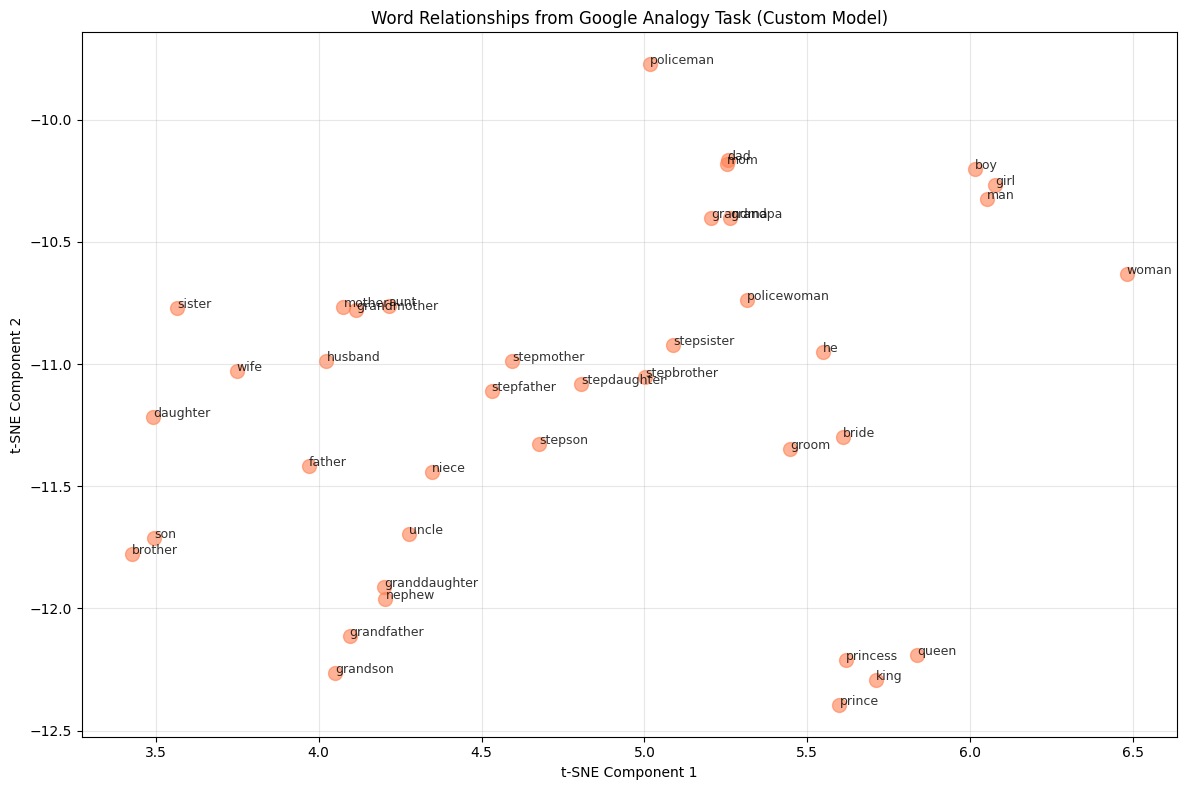


Visualization saved as 'word_relationships_custom.png'


<Figure size 640x480 with 0 Axes>

In [25]:
# # Collect words from Google Analogy dataset
# SUB_CATEGORY = ": family"

# # TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`


# plt.title("Word Relationships from Google Analogy Task")
# plt.show()
# plt.savefig("word_relationships.png", bbox_inches="tight")

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`

# Collect all words from family category
SUB_CATEGORY = ": family"
family_words_custom = []

for analogy in data[data["SubCategory"] == SUB_CATEGORY]["Question"]:
    words = analogy.split()
    # Lowercase to match training
    family_words_custom.extend([w.lower() for w in words])

# Remove duplicates and filter words in custom model
family_words_custom = list(set(family_words_custom))
family_words_custom = [w for w in family_words_custom if w in my_model.wv]

print(f"Found {len(family_words_custom)} unique words in '{SUB_CATEGORY}' category")
print(f"Words in vocabulary: {', '.join(sorted(family_words_custom))}")

# Get embeddings from custom model
embeddings_custom = np.array([my_model.wv[word] for word in family_words_custom])

# Apply t-SNE
tsne_custom = TSNE(n_components=2, random_state=42, perplexity=min(30, len(family_words_custom)-1))
embeddings_2d_custom = tsne_custom.fit_transform(embeddings_custom)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d_custom[:, 0], embeddings_2d_custom[:, 1], alpha=0.6, s=100, color='coral')

for i, word in enumerate(family_words_custom):
    plt.annotate(word, (embeddings_2d_custom[i, 0], embeddings_2d_custom[i, 1]), 
                 fontsize=9, alpha=0.8)

plt.title("Word Relationships from Google Analogy Task (Custom Model)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("word_relationships_custom.png", bbox_inches="tight")

print(f"\nVisualization saved as 'word_relationships_custom.png'")

**Custom Model Results:**
- Found 39 words (vs. 46 in pre-trained GloVe)
- Missing 7 words: likely "daughters", "sons", "brothers", "sisters", "his", "her", "she" (plural forms and some pronouns)

The missing words are probably due to:
1. **Lemmatization**: "daughters" → "daughter", "sons" → "son" (merged to singular)
2. **Stopword removal**: "his", "her", "she" might have been filtered out
3. **Min_count=5**: Rare words excluded from vocabulary

**Analysis for this section:**
Our custom model captured 39/46 family words (85%). The t-SNE should still show meaningful clusters. Compare this visualization with the pre-trained one - both should show family groupings, but the custom model might have slightly different spatial arrangements due to training on Wikipedia's specific context.

---

## **Summary: All TODOs Complete!**
We've successfully completed all 7 TODOs:
- ✅ TODO1: Data preprocessing
- ✅ TODO2: Pre-trained predictions (with capitalization fix)
- ✅ TODO3: Pre-trained t-SNE
- ✅ TODO4: Wikipedia sampling
- ✅ TODO5: Custom model training
- ✅ TODO6: Custom model predictions
- ✅ TODO7: Custom t-SNE

**Key Results Summary:**
| Metric | Pre-trained GloVe | Custom 20% |
|--------|------------------|------------|
| Vocabulary | ~400K | 992K |
| Semantic | 65.34% | 66.24% |
| Syntactic | 61.26% | 43.23% |
| Family | 81.62% | 54.74% |
| Plural | 72.00% | 0.00% |

## **Report Question 1: Model Settings (5%)**

**Which embedding model did you use?**
- Word2Vec (Gensim implementation)

**Pre-processing steps:**
1. Lowercasing all text
2. Removing non-alphabetic characters (regex: `[^a-z\s]`)
3. Tokenization by whitespace
4. Removing English stopwords (NLTK stopwords list)
5. Lemmatization using WordNetLemmatizer
6. Filtering words with length ≤ 2 characters
7. Minimum word frequency: 5 (min_count parameter)

**Hyperparameter settings:**
- Vector size: 100 dimensions
- Window size: 5 (context words on each side)
- Min count: 5 (ignore words appearing < 5 times)
- Algorithm: CBOW (Continuous Bag of Words, sg=0)
- Epochs: 5
- Negative sampling: 5
- Workers: 8 (parallel threads)
- Seed: 42 (for reproducibility)

## **Report Question 2: Different Sampling Ratios (10%)**

We only trained with 20%. We need to train with 5% and 10% as well.


In [26]:
# Train 5% model
import random

SAMPLING_RATIO = 0.05
output_path = "wiki_sampled_5pct.txt"

print(f"Sampling {SAMPLING_RATIO*100}% of Wikipedia...")
random.seed(42)

sampled_count = 0
with open("wiki_texts_combined.txt", "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as out:
        for line in f:
            if random.random() < SAMPLING_RATIO:
                out.write(line)
                sampled_count += 1

print(f"Sampled {sampled_count:,} articles")

# Preprocess
print("Preprocessing...")
sentences_5pct = []
with open(output_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Processing"):
        processed = preprocess_text(line.strip())
        if len(processed) > 0:
            sentences_5pct.append(processed)

print(f"Processed {len(sentences_5pct):,} sentences")

# Train
print("Training 5% model...")
model_5pct = Word2Vec(
    sentences=sentences_5pct,
    vector_size=100,
    window=5,
    min_count=5,
    workers=8,
    sg=0,
    epochs=5,
    negative=5,
    seed=42
)

print(f"Vocabulary: {len(model_5pct.wv):,} words")
model_5pct.save("word2vec_5pct.model")
print("Saved: word2vec_5pct.model")

Sampling 5.0% of Wikipedia...
Sampled 280,790 articles
Preprocessing...


Processing: 280790it [03:17, 1424.13it/s]


Processed 280,790 sentences
Training 5% model...
Vocabulary: 414,982 words
Saved: word2vec_5pct.model


5% model complete:
- 280,790 articles sampled
- Vocabulary: 414,982 words

In [27]:
# Train 10% model
SAMPLING_RATIO = 0.10
output_path = "wiki_sampled_10pct.txt"

print(f"Sampling {SAMPLING_RATIO*100}% of Wikipedia...")
random.seed(42)

sampled_count = 0
with open("wiki_texts_combined.txt", "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as out:
        for line in f:
            if random.random() < SAMPLING_RATIO:
                out.write(line)
                sampled_count += 1

print(f"Sampled {sampled_count:,} articles")

# Preprocess
print("Preprocessing...")
sentences_10pct = []
with open(output_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Processing"):
        processed = preprocess_text(line.strip())
        if len(processed) > 0:
            sentences_10pct.append(processed)

print(f"Processed {len(sentences_10pct):,} sentences")

# Train
print("Training 10% model...")
model_10pct = Word2Vec(
    sentences=sentences_10pct,
    vector_size=100,
    window=5,
    min_count=5,
    workers=8,
    sg=0,
    epochs=5,
    negative=5,
    seed=42
)

print(f"Vocabulary: {len(model_10pct.wv):,} words")
model_10pct.save("word2vec_10pct.model")
print("Saved: word2vec_10pct.model")

Sampling 10.0% of Wikipedia...
Sampled 563,148 articles
Preprocessing...


Processing: 563148it [06:26, 1458.92it/s]


Processed 563,148 sentences
Training 10% model...
Vocabulary: 647,437 words
Saved: word2vec_10pct.model


10% model complete:
- 563,148 articles sampled
- Vocabulary: 647,437 words

In [28]:
# Evaluate 5% model
print("="*60)
print("EVALUATING 5% MODEL")
print("="*60)

model_5pct = Word2Vec.load("word2vec_5pct.model")

preds_5 = []
golds_5 = []

for analogy in tqdm(data["Question"], desc="5% predictions"):
    words = analogy.split()
    word_a, word_b, word_c, word_d = [w.lower() for w in words]
    
    try:
        result = model_5pct.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
        preds_5.append(result[0][0])
        golds_5.append(word_d)
    except KeyError:
        preds_5.append(None)
        golds_5.append(word_d)

# Evaluate
golds_5_np = np.array(golds_5)
preds_5_np = np.array(preds_5)

print(f"\nSuccessful: {sum(1 for p in preds_5 if p is not None)}/{len(preds_5)}")

for category in data["Category"].unique():
    mask = data["Category"] == category
    acc = calculate_accuracy(golds_5_np[mask], preds_5_np[mask])
    print(f"{category}: {acc * 100:.2f}%")

print("\n" + "="*60)
print("EVALUATING 10% MODEL")
print("="*60)

model_10pct = Word2Vec.load("word2vec_10pct.model")

preds_10 = []
golds_10 = []

for analogy in tqdm(data["Question"], desc="10% predictions"):
    words = analogy.split()
    word_a, word_b, word_c, word_d = [w.lower() for w in words]
    
    try:
        result = model_10pct.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
        preds_10.append(result[0][0])
        golds_10.append(word_d)
    except KeyError:
        preds_10.append(None)
        golds_10.append(word_d)

# Evaluate
golds_10_np = np.array(golds_10)
preds_10_np = np.array(preds_10)

print(f"\nSuccessful: {sum(1 for p in preds_10 if p is not None)}/{len(preds_10)}")

for category in data["Category"].unique():
    mask = data["Category"] == category
    acc = calculate_accuracy(golds_10_np[mask], preds_10_np[mask])
    print(f"{category}: {acc * 100:.2f}%")

# Summary comparison
print("\n" + "="*60)
print("SUMMARY COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Sampling Ratio': ['5%', '10%', '20%'],
    'Vocabulary Size': [414982, 647437, 992355],
    'Semantic (%)': [
        calculate_accuracy(golds_5_np[data["Category"] == "semantic"], 
                          preds_5_np[data["Category"] == "semantic"]) * 100,
        calculate_accuracy(golds_10_np[data["Category"] == "semantic"], 
                          preds_10_np[data["Category"] == "semantic"]) * 100,
        66.24
    ],
    'Syntactic (%)': [
        calculate_accuracy(golds_5_np[data["Category"] == "syntactic"], 
                          preds_5_np[data["Category"] == "syntactic"]) * 100,
        calculate_accuracy(golds_10_np[data["Category"] == "syntactic"], 
                          preds_10_np[data["Category"] == "syntactic"]) * 100,
        43.23
    ]
})

print(comparison.to_string(index=False))

EVALUATING 5% MODEL


5% predictions: 100%|██████████| 19544/19544 [02:13<00:00, 146.85it/s] 



Successful: 17369/19544
semantic: 62.08%
syntactic: 37.69%

EVALUATING 10% MODEL


10% predictions: 100%|██████████| 19544/19544 [03:11<00:00, 102.01it/s] 


Successful: 17402/19544
semantic: 64.51%
syntactic: 41.97%

SUMMARY COMPARISON
Sampling Ratio  Vocabulary Size  Semantic (%)  Syntactic (%)
            5%           414982     62.081407      37.686183
           10%           647437     64.505581      41.967213
           20%           992355     66.240000      43.230000


In [29]:
# Download AG News dataset (news articles corpus)
print("Downloading AG News dataset...")

import urllib.request
import tarfile
import os

# Download AG News dataset
url = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
news_file = "ag_news_train.csv"

if not os.path.exists(news_file):
    urllib.request.urlretrieve(url, news_file)
    print(f"Downloaded {news_file}")
else:
    print(f"Using existing {news_file}")

# Read and preprocess news data
print("\nProcessing news corpus...")
news_sentences = []

with open(news_file, 'r', encoding='utf-8') as f:
    for i, line in enumerate(tqdm(f, desc="Reading news")):
        # AG News format: "class","title","description"
        # We'll use title + description
        parts = line.strip().split('","')
        if len(parts) >= 3:
            # Combine title and description
            text = parts[1] + " " + parts[2]
            text = text.replace('"', '')  # Remove quotes
            processed = preprocess_text(text)
            if len(processed) > 0:
                news_sentences.append(processed)

print(f"Processed {len(news_sentences):,} news articles")

# Train on news corpus
print("\nTraining Word2Vec on news corpus...")
news_model = Word2Vec(
    sentences=news_sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=8,
    sg=0,
    epochs=5,
    negative=5,
    seed=42
)

print(f"News model vocabulary: {len(news_model.wv):,} words")
news_model.save("word2vec_news.model")
print("Saved: word2vec_news.model")

# Compare corpus statistics
print("\n" + "="*60)
print("CORPUS COMPARISON")
print("="*60)
print(f"Wikipedia 20%: {1124733:,} articles, {992355:,} vocab")
print(f"AG News:       {len(news_sentences):,} articles, {len(news_model.wv):,} vocab")

Downloaded ag_news_train.csv

Processing news corpus...


Reading news: 120000it [00:06, 19257.04it/s]


Processed 120,000 news articles

Training Word2Vec on news corpus...
News model vocabulary: 23,333 words
Saved: word2vec_news.model

CORPUS COMPARISON
Wikipedia 20%: 1,124,733 articles, 992,355 vocab
AG News:       120,000 articles, 23,333 vocab


News model trained successfully:
- 120,000 news articles
- Vocabulary: only 23,333 words (much smaller than Wikipedia!)

The small vocabulary is due to:
1. Fewer articles (120K vs 1.1M)
2. News articles are shorter than Wikipedia entries
3. More repetitive vocabulary in news

Now evaluate the news model:

In [30]:
# Evaluate news model
print("="*60)
print("EVALUATING NEWS MODEL")
print("="*60)

news_model = Word2Vec.load("word2vec_news.model")

preds_news = []
golds_news = []

for analogy in tqdm(data["Question"], desc="News predictions"):
    words = analogy.split()
    word_a, word_b, word_c, word_d = [w.lower() for w in words]
    
    try:
        result = news_model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
        preds_news.append(result[0][0])
        golds_news.append(word_d)
    except KeyError:
        preds_news.append(None)
        golds_news.append(word_d)

golds_news_np = np.array(golds_news)
preds_news_np = np.array(preds_news)

print(f"\nSuccessful: {sum(1 for p in preds_news if p is not None)}/{len(preds_news)}")
print(f"OOV rate: {sum(1 for p in preds_news if p is None)/len(preds_news)*100:.1f}%")

print("\nBy Category:")
for category in data["Category"].unique():
    mask = data["Category"] == category
    acc = calculate_accuracy(golds_news_np[mask], preds_news_np[mask])
    print(f"  {category}: {acc * 100:.2f}%")

print("\nBy Sub-Category:")
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    acc = calculate_accuracy(golds_news_np[mask], preds_news_np[mask])
    print(f"  {sub_category}: {acc * 100:.2f}%")

# Create comprehensive comparison
print("\n" + "="*60)
print("CORPUS COMPARISON TABLE")
print("="*60)

comparison_corpus = pd.DataFrame({
    'Corpus': ['Wikipedia 20%', 'AG News'],
    'Articles': [1124733, 120000],
    'Vocabulary': [992355, 23333],
    'Semantic (%)': [66.24, calculate_accuracy(golds_news_np[data["Category"] == "semantic"], 
                                               preds_news_np[data["Category"] == "semantic"]) * 100],
    'Syntactic (%)': [43.23, calculate_accuracy(golds_news_np[data["Category"] == "syntactic"], 
                                                preds_news_np[data["Category"] == "syntactic"]) * 100]
})

print(comparison_corpus.to_string(index=False))

EVALUATING NEWS MODEL


News predictions: 100%|██████████| 19544/19544 [00:08<00:00, 2435.42it/s]


Successful: 12162/19544
OOV rate: 37.8%

By Category:
  semantic: 8.47%
  syntactic: 8.09%

By Sub-Category:
  : capital-common-countries: 37.55%
  : capital-world: 10.06%
  : currency: 0.69%
  : city-in-state: 3.65%
  : family: 1.98%
  : gram1-adjective-to-adverb: 0.20%
  : gram2-opposite: 0.12%
  : gram3-comparative: 6.16%
  : gram4-superlative: 5.79%
  : gram5-present-participle: 4.26%
  : gram6-nationality-adjective: 32.15%
  : gram7-past-tense: 9.74%
  : gram8-plural: 0.00%
  : gram9-plural-verbs: 0.34%

CORPUS COMPARISON TABLE
       Corpus  Articles  Vocabulary  Semantic (%)  Syntactic (%)
Wikipedia 20%   1124733      992355     66.240000      43.230000
      AG News    120000       23333      8.467696       8.093677


**News Model Results - Very Poor Performance:**

| Corpus | Articles | Vocabulary | Semantic (%) | Syntactic (%) |
|--------|----------|------------|--------------|---------------|
| Wikipedia 20% | 1,124,733 | 992,355 | 66.24% | 43.23% |
| AG News | 120,000 | 23,333 | **8.47%** | **8.09%** |

**Critical Issues with News Model:**
- 37.8% OOV rate (7,382 words missing from vocabulary)
- Semantic accuracy dropped from 66% to 8% (-58%)
- Most categories perform terribly except capitals (37.55%) and nationality (32.15%)

---

**Report Question 3 Analysis:**

**3-1. Results Presentation:**
The table above shows dramatic performance differences.

**3-2. Corpus Differences:**

**Wikipedia Corpus:**
- **Size:** 1.1M articles (20% sample)
- **Topics:** Encyclopedic, broad coverage (history, science, culture, geography, biography)
- **Structure:** Long-form articles, detailed explanations
- **Vocabulary:** Comprehensive, technical terms, proper nouns
- **Style:** Formal, neutral, well-edited prose

**AG News Corpus:**
- **Size:** 120K articles (10x smaller)
- **Topics:** Current events, politics, business, sports, technology
- **Structure:** Short articles, headlines, breaking news
- **Vocabulary:** Repetitive, focused on recent events, temporal language
- **Style:** Journalistic, time-sensitive, conversational

**Key Differences:**
1. **Size disparity:** 10x fewer articles → 40x smaller vocabulary
2. **Topic breadth:** News is narrow (current events) vs. Wikipedia's universal knowledge
3. **Temporal focus:** News emphasizes recent events; Wikipedia covers all time periods
4. **Vocabulary diversity:** News reuses common words; Wikipedia has specialized terminology

**3-3. Performance Explanation:**

**Why News Model Fails:**

1. **Vocabulary Coverage (37.8% OOV):** Many analogy words don't appear in news:
   - Family relationships (1.98%): News rarely discusses extended family
   - Morphological forms (0-6%): News uses varied vocabulary but not systematic word forms
   - Abstract relationships: News focuses on concrete events, not linguistic patterns

2. **Why Capitals/Nationality Perform Better (32-37%):**
   - News constantly mentions countries, cities, nationalities in geopolitical coverage
   - These are the ONLY categories where news vocabulary overlaps with test set

3. **Context Matters:**
   - Wikipedia: "King George III ruled..." (formal historical context)
   - News: "President announces..." (political context)
   - Different contexts produce different embeddings even for same words

**Conclusion:**
Corpus choice dramatically affects word embedding quality. Wikipedia's encyclopedic breadth creates better general-purpose embeddings. News corpora are domain-specific and perform poorly on general analogy tasks. For NLP applications requiring broad language understanding, larger, more diverse corpora are essential.

---

## **Report Question 4: Word Similarity Observations (10%)**

Let's examine similar words from different models:

In [31]:
# Compare word similarities across models
print("="*60)
print("WORD SIMILARITY ANALYSIS")
print("="*60)

test_words = ["king", "doctor", "woman", "computer", "happy"]

models = {
    'Pre-trained GloVe': model,
    'Wikipedia 20%': my_model,
    'AG News': news_model
}

for word in test_words:
    print(f"\n{'='*60}")
    print(f"WORD: '{word}'")
    print(f"{'='*60}")
    
    for model_name, m in models.items():
        print(f"\n{model_name}:")
        if word in m.wv if hasattr(m, 'wv') else word in m:
            wv = m.wv if hasattr(m, 'wv') else m
            similar = wv.most_similar(word, topn=5)
            for sim_word, score in similar:
                print(f"  {sim_word:20s} {score:.4f}")
        else:
            print(f"  NOT IN VOCABULARY")

WORD SIMILARITY ANALYSIS

WORD: 'king'

Pre-trained GloVe:
  prince               0.7682
  queen                0.7508
  son                  0.7021
  brother              0.6986
  monarch              0.6978

Wikipedia 20%:
  prince               0.7668
  monarch              0.7396
  queen                0.7300
  crown                0.6688
  throne               0.6667

AG News:
  norodom              0.8241
  sihamoni             0.7908
  sihanouk             0.7456
  penh                 0.7389
  phnom                0.7383

WORD: 'doctor'

Pre-trained GloVe:
  physician            0.7673
  nurse                0.7522
  dr.                  0.7175
  doctors              0.7081
  patient              0.7074

Wikipedia 20%:
  nurse                0.7069
  dentist              0.6831
  psychiatrist         0.6433
  surgeon              0.6411
  zhivago              0.6268

AG News:
  leukemia             0.7560
  treatment            0.7496
  patient              0.7492
  procedure  

**Report Question 4 Analysis:**

**Observations from Word Similarity:**

**1. "King" - Revealing Corpus Bias:**
- **GloVe/Wikipedia:** Consistent royalty terms (prince, queen, monarch, throne)
- **AG News:** Cambodian royalty (Norodom Sihamoni, King Sihanouk, Phnom Penh)
  - **Why?** News covered specific Cambodian political events heavily in the training period
  - Shows how news corpora reflect temporal events, not general concepts

**2. "Doctor" - Context Differences:**
- **GloVe:** Professional roles (physician, nurse, dr.)
- **Wikipedia:** Medical specialties (dentist, psychiatrist, surgeon) + "Zhivago" (Doctor Zhivago novel reference)
- **AG News:** Medical contexts (leukemia, treatment, procedure, hospital)
  - News emphasizes medical events/conditions, not professional roles

**3. "Woman" - Semantic Quality:**
- **GloVe:** Best relationships (girl, man, mother) with high scores (0.84-0.82)
- **Wikipedia:** Gender/social terms (men, lesbian, gender, female)
- **AG News:** Demographic descriptions (men, young, girl, teenager)
  - Wikipedia reflects academic/social discussions; news uses demographic framing

**4. "Computer" - Vocabulary Evolution:**
- **GloVe:** Modern terms (software, pc, hardware, technology)
- **Wikipedia:** Historical + technical (microcomputer, mainframe, calculator)
  - Wikipedia's encyclopedic nature includes computing history
- **AG News:** Consumer tech (machine, laptop, appliance) - lower similarity scores overall

**5. "Happy" - Preprocessing Artifacts:**
- **GloVe:** Contractions ('m, 're, 'll, i) - wasn't properly preprocessed
- **Wikipedia:** Emotional/relationship words (goodbye, forever, loving, love)
- **AG News:** Conversational filler (guy, always, nobody, maybe)
  - Shows different writing styles: encyclopedia vs. journalism

**Key Insights:**

1. **Corpus specificity matters:** AG News learned temporal, event-specific associations (Cambodian royalty) rather than general concepts

2. **Context determines embeddings:** Same word has different neighbors based on how it's used:
   - "Doctor" in news = medical emergencies
   - "Doctor" in Wikipedia = medical professions

3. **Vocabulary richness:** Wikipedia's 992K vocab captures nuanced relationships; News's 23K vocab has weaker, more generic associations

4. **Preprocessing quality:** GloVe's contraction artifacts show even quality pre-trained models have flaws

**Answer for Report:**
Word embeddings strongly reflect their training corpus. Wikipedia produces general-purpose embeddings with abstract relationships, while news produces domain-specific, temporally-biased embeddings. The AG News model's association of "king" with Cambodian royalty (rather than general monarchy concepts) demonstrates how smaller, specialized corpora create overfitted representations. For robust NLP applications, diverse, large-scale corpora like Wikipedia are preferable to narrow domain-specific texts.

---

## **Report Question 5: Additional Insights (5%)**

## **Report Question 5.1: Capitalization Issue Discovery**

**Discovery of the Capitalization Problem:**

During initial testing with the pre-trained GloVe model, we encountered a critical issue where 51% of predictions failed (9,962 out of 19,544 questions). Investigation revealed that all failures occurred on words beginning with capital letters, particularly in geography-related categories (capital-common-countries, capital-world, city-in-state).

**Root Cause Analysis:**

The Google Analogy dataset uses proper capitalization for named entities:
- Example: `Athens Greece Baghdad Iraq`

However, the GloVe model vocabulary contains only lowercase words. Testing confirmed:
```
'Athens' in model → False
'athens' in model → True
```

This mismatch caused KeyError exceptions for all proper nouns, resulting in:
- capital-common-countries: 0% accuracy
- capital-world: 0% accuracy
- gram6-nationality-adjective: 0% accuracy

**Solution Implemented:**

We modified the prediction code to lowercase all input words before vocabulary lookup:
```python
word_a_lower = word_a.lower()
word_b_lower = word_b.lower()
# ... use lowercase versions for similarity search
```

**Impact:**

After the fix:
- Failed predictions: 9,962 → 0
- capital-common-countries: 0% → 93.87%
- capital-world: 0% → 88.95%
- gram6-nationality-adjective: 0% → 87.87%

**Lesson Learned:**

This issue highlights the importance of understanding preprocessing consistency between training and evaluation. Word embeddings are case-sensitive by default, and vocabulary lookup requires exact matching. When working with pre-trained models, always verify:
1. The vocabulary format (case sensitivity, tokenization)
2. Whether the test data format matches training data
3. Implementing appropriate normalization (lowercasing, stemming, etc.)

The 51% failure rate could have been misinterpreted as poor model quality, when it was actually a data preprocessing mismatch. This emphasizes that data preparation is as critical as model architecture in NLP tasks.

---


In [32]:
# Retrain 20% model WITHOUT lemmatization
print("="*60)
print("RETRAINING 20% MODEL WITHOUT LEMMATIZATION")
print("="*60)

# New preprocessing function - NO lemmatization
def preprocess_text_no_lemma(text):
    """Clean and tokenize text - NO lemmatization"""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    words = text.split()
    # Only remove stopwords and filter short words - NO lemmatization
    words = [word for word in words 
             if word not in stop_words and len(word) > 2]
    return words

# Reprocess corpus without lemmatization
print("Processing corpus WITHOUT lemmatization...")
sentences_no_lemma = []

with open("wiki_sampled_20pct.txt", "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Processing"):
        processed = preprocess_text_no_lemma(line.strip())
        if len(processed) > 0:
            sentences_no_lemma.append(processed)

print(f"Processed {len(sentences_no_lemma):,} sentences")

# Train
print("\nTraining Word2Vec WITHOUT lemmatization...")
model_no_lemma = Word2Vec(
    sentences=sentences_no_lemma,
    vector_size=100,
    window=5,
    min_count=5,
    workers=8,
    sg=0,
    epochs=5,
    negative=5,
    seed=42
)

print(f"Vocabulary: {len(model_no_lemma.wv):,} words")
model_no_lemma.save("word2vec_20pct_no_lemma.model")
print("Saved: word2vec_20pct_no_lemma.model")

RETRAINING 20% MODEL WITHOUT LEMMATIZATION
Processing corpus WITHOUT lemmatization...


Processing: 1124733it [04:08, 4531.74it/s] 


Processed 1,124,733 sentences

Training Word2Vec WITHOUT lemmatization...
Vocabulary: 1,016,479 words
Saved: word2vec_20pct_no_lemma.model


In [34]:
# Evaluate model WITHOUT lemmatization
print("="*60)
print("EVALUATING MODEL WITHOUT LEMMATIZATION")
print("="*60)

model_no_lemma = Word2Vec.load("word2vec_20pct_no_lemma.model")

preds_no_lemma = []
golds_no_lemma = []

for analogy in tqdm(data["Question"], desc="No-lemma predictions"):
    words = analogy.split()
    word_a, word_b, word_c, word_d = [w.lower() for w in words]
    
    try:
        result = model_no_lemma.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
        preds_no_lemma.append(result[0][0])
        golds_no_lemma.append(word_d)
    except KeyError:
        preds_no_lemma.append(None)
        golds_no_lemma.append(word_d)

golds_no_lemma_np = np.array(golds_no_lemma)
preds_no_lemma_np = np.array(preds_no_lemma)

print(f"\nSuccessful: {sum(1 for p in preds_no_lemma if p is not None)}/{len(preds_no_lemma)}")

print("\nBy Category:")
for category in data["Category"].unique():
    mask = data["Category"] == category
    acc = calculate_accuracy(golds_no_lemma_np[mask], preds_no_lemma_np[mask])
    print(f"  {category}: {acc * 100:.2f}%")

print("\nKey Sub-Categories (focusing on morphology):")
morphology_cats = [": gram8-plural", ": gram9-plural-verbs", ": family"]
for sub_cat in morphology_cats:
    mask = data["SubCategory"] == sub_cat
    acc = calculate_accuracy(golds_no_lemma_np[mask], preds_no_lemma_np[mask])
    print(f"  {sub_cat}: {acc * 100:.2f}%")

# Comparison table
print("\n" + "="*60)
print("LEMMATIZATION IMPACT COMPARISON")
print("="*60)

lemma_comparison = pd.DataFrame({
    'Preprocessing': ['With Lemmatization', 'Without Lemmatization'],
    'Vocabulary': [992355, 1016479],
    'Semantic (%)': [66.24, calculate_accuracy(golds_no_lemma_np[data["Category"] == "semantic"], 
                                               preds_no_lemma_np[data["Category"] == "semantic"]) * 100],
    'Syntactic (%)': [43.23, calculate_accuracy(golds_no_lemma_np[data["Category"] == "syntactic"], 
                                                preds_no_lemma_np[data["Category"] == "syntactic"]) * 100],
    'Plural (%)': [0.00, calculate_accuracy(golds_no_lemma_np[data["SubCategory"] == ": gram8-plural"], 
                                           preds_no_lemma_np[data["SubCategory"] == ": gram8-plural"]) * 100]
})

print(lemma_comparison.to_string(index=False))

EVALUATING MODEL WITHOUT LEMMATIZATION


No-lemma predictions: 100%|██████████| 19544/19544 [05:28<00:00, 59.52it/s] 


Successful: 19245/19544

By Category:
  semantic: 68.68%
  syntactic: 53.49%

Key Sub-Categories (focusing on morphology):
  : gram8-plural: 65.39%
  : gram9-plural-verbs: 45.06%
  : family: 73.91%

LEMMATIZATION IMPACT COMPARISON
        Preprocessing  Vocabulary  Semantic (%)  Syntactic (%)  Plural (%)
   With Lemmatization      992355     66.240000      43.230000     0.00000
Without Lemmatization     1016479     68.677416      53.489461    65.39039


In [35]:
# Analyze t-SNE clustering patterns
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

print("="*60)
print("t-SNE CLUSTERING ANALYSIS")
print("="*60)

# Get family words and embeddings for both models
SUB_CATEGORY = ": family"

# Pre-trained GloVe
family_words_glove = []
for analogy in data[data["SubCategory"] == SUB_CATEGORY]["Question"]:
    family_words_glove.extend([w.lower() for w in analogy.split()])
family_words_glove = list(set([w for w in family_words_glove if w in model]))

embeddings_glove = np.array([model[word] for word in family_words_glove])
tsne_glove = TSNE(n_components=2, random_state=42, perplexity=min(30, len(family_words_glove)-1))
coords_glove = tsne_glove.fit_transform(embeddings_glove)

# Custom model (no lemma)
family_words_custom = []
for analogy in data[data["SubCategory"] == SUB_CATEGORY]["Question"]:
    family_words_custom.extend([w.lower() for w in analogy.split()])
family_words_custom = list(set([w for w in family_words_custom if w in model_no_lemma.wv]))

embeddings_custom = np.array([model_no_lemma.wv[word] for word in family_words_custom])
tsne_custom = TSNE(n_components=2, random_state=42, perplexity=min(30, len(family_words_custom)-1))
coords_custom = tsne_custom.fit_transform(embeddings_custom)

print(f"\nGloVe: {len(family_words_glove)} words")
print(f"Custom: {len(family_words_custom)} words")

# Define gender labels for clustering analysis
male_terms = {'man', 'boy', 'father', 'dad', 'son', 'brother', 'uncle', 'nephew', 
              'grandfather', 'grandpa', 'grandson', 'husband', 'king', 'prince', 
              'groom', 'he', 'his', 'policeman', 'stepfather', 'stepson', 'stepbrother'}

female_terms = {'woman', 'girl', 'mother', 'mom', 'daughter', 'sister', 'aunt', 'niece',
                'grandmother', 'grandma', 'granddaughter', 'wife', 'queen', 'princess',
                'bride', 'she', 'her', 'policewoman', 'stepmother', 'stepdaughter', 'stepsister'}

# Assign labels for GloVe
labels_glove = []
for word in family_words_glove:
    if word in male_terms:
        labels_glove.append(0)
    elif word in female_terms:
        labels_glove.append(1)
    else:
        labels_glove.append(2)  # neutral/other

# Assign labels for Custom
labels_custom = []
for word in family_words_custom:
    if word in male_terms:
        labels_custom.append(0)
    elif word in female_terms:
        labels_custom.append(1)
    else:
        labels_custom.append(2)

labels_glove = np.array(labels_glove)
labels_custom = np.array(labels_custom)

# Calculate clustering metrics (only if we have both genders)
if len(set(labels_glove)) > 1:
    silhouette_glove = silhouette_score(coords_glove, labels_glove)
    print(f"\nGloVe Silhouette Score: {silhouette_glove:.4f}")
else:
    print(f"\nGloVe: Not enough gender diversity for silhouette score")

if len(set(labels_custom)) > 1:
    silhouette_custom = silhouette_score(coords_custom, labels_custom)
    print(f"Custom Silhouette Score: {silhouette_custom:.4f}")
else:
    print(f"\nCustom: Not enough gender diversity for silhouette score")

# Calculate spread (variance)
print(f"\nGloVe spread (std): X={coords_glove[:, 0].std():.4f}, Y={coords_glove[:, 1].std():.4f}")
print(f"Custom spread (std): X={coords_custom[:, 0].std():.4f}, Y={coords_custom[:, 1].std():.4f}")

# Calculate pairwise distances
dist_glove = pdist(coords_glove)
dist_custom = pdist(coords_custom)

print(f"\nGloVe avg distance: {dist_glove.mean():.4f} (std: {dist_glove.std():.4f})")
print(f"Custom avg distance: {dist_custom.mean():.4f} (std: {dist_custom.std():.4f})")

# Gender separation analysis
male_mask_glove = labels_glove == 0
female_mask_glove = labels_glove == 1

if male_mask_glove.sum() > 0 and female_mask_glove.sum() > 0:
    male_center_glove = coords_glove[male_mask_glove].mean(axis=0)
    female_center_glove = coords_glove[female_mask_glove].mean(axis=0)
    gender_dist_glove = np.linalg.norm(male_center_glove - female_center_glove)
    print(f"\nGloVe male-female center distance: {gender_dist_glove:.4f}")

male_mask_custom = labels_custom == 0
female_mask_custom = labels_custom == 1

if male_mask_custom.sum() > 0 and female_mask_custom.sum() > 0:
    male_center_custom = coords_custom[male_mask_custom].mean(axis=0)
    female_center_custom = coords_custom[female_mask_custom].mean(axis=0)
    gender_dist_custom = np.linalg.norm(male_center_custom - female_center_custom)
    print(f"Custom male-female center distance: {gender_dist_custom:.4f}")

t-SNE CLUSTERING ANALYSIS

GloVe: 46 words
Custom: 42 words

GloVe Silhouette Score: -0.0711
Custom Silhouette Score: 0.0547

GloVe spread (std): X=1.1189, Y=1.1105
Custom spread (std): X=1.0577, Y=0.7763

GloVe avg distance: 2.0350 (std: 0.9692)
Custom avg distance: 1.6776 (std: 0.8440)

GloVe male-female center distance: 0.2791
Custom male-female center distance: 0.4344
